# Coursera Capstone Final Project: Battle of the Neighbourhoods

## 1. Introduction and Business Problem

The goal of this project is to analyze restaurants in Boston, MA for stakeholders interested in opening a restaurant. The restaurant industry in North America is extremely competitive, and it is difficult to become successful as a small business owner in this industry. Understanding what type of restaurant to open and where is critical to success. Furthermore, while finding the optimal location for a restaurant is just the first step, it is complex. For example, a neighbourhood with no Indian restaurants could be an excellent location for a new Indian restaurant because there would be little competition. However, it could also indicate that Indian food does not appeal to restaurant-goers in this neighbourhood. Finding an optimal location to open a new restaurant is therefore a balance of 'fitting in' and 'standing out'.

Furthermore, restaurant-goers' expectations often shape their perception of a new restaurant. For example, a restaurant whose price point is higher or lower than those surrounding it may be less successful because it does not match expectations for that area. Similarly, restaurant-goers often expect ethnic food to be cheaper, which can make finding a good location for an expensive ethnic restaurant challenging.

In order to help stakeholders find an appropriate location for their business venture, we have created a machine learning model that considers the location (as lat and lon), price tier, tip count, likes, and genre of cuisine as predictors for its rating (with rating as a proxy to success). 

This project deliberately does not limit itself to stakeholders interested in opening a particular type of restaurant. Because choosing the right location takes into account a complex and subjective balance of factors, there is no one 'perfect' location for all stakeholders. The goal of this project is therefore to detect and analyze geographic trends in Manhattan restaurants so that stakeholders can decide exactly how they want to balance between'fitting in' and 'standing out'.

## 2. Data

Based on the definition of the problem above, the following data will be required to complete the project:

* price tier
* genre of cuisine (venue category)
* name of restaurant
* restaurant rating
* tip count
* likes
* location (lat and long)

All of the above information is available from foursquare. However, this information is obtained using 'premium' calls, which have a limit of 50 per day. The data below was therefore collected over 10 days, to obtain data on 500 restaurants. This was considered sufficient for analysis. Only restaurants for which all of the above data was available were considered.

The number of restaurants per category was limited to 10. This reduces the bias towards a certain category during ML algorithm development. For example, if 400 out of the 500 restaurants were fast food, this would bias the algorithm towards that restaurant category.
 
For the purpose of this analysis, 'restaurant' will be defined as any venue that primarily serves prepared meals. Bakeries, cafes, bars, and food shops are not included in the definition.

Boston was chosen for this project because of the large amount of available data and diversity of restaurant categories. This is important for determining if results are significant.


### 2.1. Restaurant Data

First, we import the necessary packages to process and analyze the data.

In [155]:
# import packages

import numpy as np 
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium
import pandas as pd
from unicodedata import normalize
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
from scipy import stats

The foursquare calls require a client ID, secret, and version. These are saved below so they can be used for all calls.

In [2]:
##Save foursquare client ID and secret for calls#############################################
CLIENT_ID = 'UM5EZ1MMXBBAIUR2BERSL0ECQCUYANKC3ZBKWHCWDSXAUHXO'
CLIENT_SECRET = 'OGSUKEERLGXANFE2YXDUDLTLGQASHHAA5CISRCEVX3DFOBG4'
VERSION = '20180605' # Foursquare API version

The first foursquare call we need to make is to get the names and IDs for all the different restaurant categories. First, we pull data for all categories, restaurants or otherwise.

In [ ]:
# url to get all categories & their IDs
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(    
      CLIENT_ID, 
      CLIENT_SECRET, 
      VERSION)
    
# make the GET request
results = requests.get(url).json()


The next step is to create a dataframe with the names and IDs of relevant restaurant categories only.
First, names and IDs of restaurant categories are pulled from the foursquare request and appended to a list.

Next, the list is transformed into a dataframe and categories that do not meet our conditions are removed.

In [ ]:
#get all venue category id & names
cat_name = []
cat_id = []

for i in range(len(results['response']['categories'][3]['categories'])):
    cat_name.append(results['response']['categories'][3]['categories'][i]['name'])
    cat_id.append(results['response']['categories'][3]['categories'][i]['id'])
    
cats = pd.DataFrame({'category': cat_name, 'cat_id': cat_id})
cats_del = ['Bakery','Bubble Tea Shop', 'Café', 'Cafeteria', 'Coffee Shop', 'Creperie', 'Dessert Shop', 'Donut Shop',
           'Food Court', 'Food Truck', 'Juice Bar', 'Pet Café', 'Restaurant', 'Snack Place', 'Tea Room']
cats = cats[~cats['category'].isin(cats_del)]

print(cats.shape)
cats.head()

Once we have the category IDs, we can get the IDs of venues in these specific categories. To ensure a fairly even distribution of venues by category, we limit the number of venues per category to 10. This ensures that even if, for example, there are many more American restaurants than Afghan restaurants in Boston, the data will not be biased in favour of American restaurants. 
We first create a function that pulls a maximum of 10 venue IDs within multiple specified categories, then call this function based on the category IDs we collected for restaurants.

In [ ]:
###function to get venue IDs

def getVenueIDs(near,cat_ids,limit):
    venues_list = []
    venue_category = []
    lats = []
    lons = []
    
    venues = pd.DataFrame({'venue_id': venues_list, 'cat_id': venue_category,'lat': lats, 'lon':lons})
    
    for cat in range(len(cat_ids)):
        category = cat_ids[cat]
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            near,
            limit,
            category)
    
         # make the GET request (formatted to avoid key errors if groups not found)
        results = requests.get(url).json()
        
        # return only relevant information for each nearby venue
        for i in range(len(results['response']['groups'][0]['items'])):
            venue_category.append(category)
            
            try:
                venues_list.append(results['response']['groups'][0]['items'][i]['venue']['id'])
            except KeyError:
                venues_list.append('NaN')
                  
            try:
                lats.append(results['response']['groups'][0]['items'][i]['venue']['location']['lat'])
            except KeyError:
                lats.append('NaN')
                
            try:
                lons.append(results['response']['groups'][0]['items'][i]['venue']['location']['lng'])
            except KeyError:
                lons.append('NaN')
        
                
        venue_info = pd.DataFrame({'venue_id': venues_list, 'cat_id': venue_category,'lat': lats, 'lon':lons})
        
        venues = pd.concat([venues,venue_info])
    
    return(venues)

limit = 10
near = 'Boston, MA'
cat_ids = cats['cat_id'].tolist()

venues = getVenueIDs(near,cat_ids,limit).reset_index(drop = True)

Our venue IDs dataframe contains the category ID but not the category name, which is more useful. We therefore merge the venue ID dataframe with the category dataframe to get the category name, then drop the category ID column.

In [ ]:
venues = venues.merge(cats, on = 'cat_id')
venues = venues[~venues.duplicated(subset=['venue_id'])].reset_index(drop = True)
print(venues.shape)
venues.head()

In order to avoid redoing these calls/processes every time we run the script, we save the venue and category dataframes as pickles then load them as needed. This reduces runtime and saves space.

In [269]:
# save up to this point as pickle (so don't have to repeat api call)
venues.to_pickle("./venues.pkl")
cats.to_pickle("./cats.pkl")

#upload saved pickle
venues = pd.read_pickle("./venues.pkl")
cats = pd.read_pickle("./cats.pkl")

Finally, we are ready to obtain the data on each venue needed to create a predictive algorithm. We create a function that pulls the venue name, tip count, price tier, likes, and rating information for each venue. Because obtaining this data requires using foursquare premium calls, which are limited to 50 per day for non-premium accounts, we run the function 10 times over the course of 10 days for a subset of 50 venues per run. After each day is run, the data is saved as a pickle.

In [22]:
#function to get dat for each venue based on its ID

def getVenueData(venue_ids_list):
    columns = ['venue_id','venue_name','tipCount','pricetier',
                'likes','rating']
    
    venue_name = []
    tipcount = []
    pricetier = []
    likes = []
    rating = []
    venue_id = []
    
    for i in range(len(venue_ids_list)):
        venueid = venue_ids_list[i]
        venue_id.append(venueid)
        
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venueid,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
        results = requests.get(url).json()
        
        try:    
            venue_name.append(results['response']['venue']['name'])
        except KeyError:
            venue_name.append('NaN')  
            
        try:    
            tipcount.append(results['response']['venue']['stats']['tipCount'])
        except KeyError:
            tipcount.append('NaN')   
            
        try:    
            pricetier.append(results['response']['venue']['price']['tier'])
        except KeyError:
            pricetier.append('NaN')     
            
        try:   
            likes.append(results['response']['venue']['likes']['count'])
        except KeyError:
            likes.append('NaN')  
            
        try:   
            rating.append(results['response']['venue']['rating'])
        except KeyError:
            rating.append('NaN')  
         
    df = pd.DataFrame({'venue_id':venue_id,'venue_name':venue_name,'tipCount':tipcount, 
                           'pricetier':pricetier,'likes':likes,'rating':rating})
    
    return df


In [23]:
#get venue data 50 at a time (max premium calls per day)
venues_1 = venues.loc[:49,:]
venues_2 = venues.loc[50:99,:]
venues_3 = venues.loc[100:149,:]
venues_4 = venues.loc[150:199,:]
venues_5 = venues.loc[200:249,:]
venues_6 = venues.loc[250:299,:]
venues_7 = venues.loc[300:349,:]
venues_8 = venues.loc[350:399,:]
venues_9 = venues.loc[400:449,:]
venues_10 = venues.loc[450:,:]

In [54]:
#Run function for subset of venues (10 times)
venue_dat_10 = getVenueData(venues_10['venue_id'].tolist())

#save as pickle
venue_dat_10.to_pickle("./venue_dat_10.pkl")

,venue_id,venue_name,tipCount,pricetier,likes,rating
0,4bf202d970779521b5a43e7c,Istanbul'lu,25,2,79,8.6
1,4b23e678f964a520675c24e3,Pasha Turkish & Mediterranean Cuisine,21,2,43,8.1
2,4b1d37d2f964a520290d24e3,Café Mangal,9,4,28,8.9
3,560ed34c498eafa18977c323,Gyro & Kebab House,8,2,33,8.4
4,4a9f1e93f964a520983c20e3,Brookline Family Restaurant,30,2,49,6.3
5,4d5c098e5d1537040d9e6de7,Mediterranean Turkish Food,6,2,15,7
6,5b7890d535d3fc002cde6c41,Anatolia,3,2,2,NaN
7,579a08c2498e7c745ebce4a8,Home,0,NaN,0,NaN
8,577be842498e0a21aa1cc211,Clover Food Lab FIN,9,2,63,8.8
9,5605cfde498e93568a705014,Whole Heart Provisions,18,2,52,9


After saving each data subset as a pickle, we load all 10 pickles and concatenate them into a single table. We remove any duplicate venue IDs.

In [57]:
#load pickles
venues_dat_1 = pd.read_pickle("./venue_dat_1.pkl")
venues_dat_2 = pd.read_pickle("./venue_dat_2.pkl")
venues_dat_3 = pd.read_pickle("./venue_dat_3.pkl")
venues_dat_4 = pd.read_pickle("./venue_dat_4.pkl")
venues_dat_5 = pd.read_pickle("./venue_dat_5.pkl")
venues_dat_6 = pd.read_pickle("./venue_dat_6.pkl")
venues_dat_7 = pd.read_pickle("./venue_dat_7.pkl")
venues_dat_8 = pd.read_pickle("./venue_dat_8.pkl")
venues_dat_9 = pd.read_pickle("./venue_dat_9.pkl")
venues_dat_10 = pd.read_pickle("./venue_dat_10.pkl")

In [280]:
# merge loaded pickles
venues_dat = pd.concat([venues_dat_1, venues_dat_2, venues_dat_3, venues_dat_4, venues_dat_5,
                       venues_dat_6, venues_dat_7, venues_dat_8, venues_dat_9, venues_dat_10], 
                       ignore_index=True)
venues_dat.drop_duplicates(subset=['venue_id'], inplace = True)

Finally, we merge this dataframe with the venue name dataframe from earlier, which also contains latitude and longitude data. The dataframe is now ready to be processed for algorithm development.

In [197]:
# merge venue data with venues to get lat/lon
boston_venues = pd.merge(venues_dat, venues, on = 'venue_id')
boston_venues = boston_venues.replace('NaN',np.nan).dropna()
boston_venues = boston_venues.drop(columns=['venue_id','cat_id'])
boston_venues.head()

,venue_name,tipCount,pricetier,likes,rating,lat,lon,category
0,Ariana Restaurant,20,2.0,38,8.3,42.362593,-71.138953,Afghan Restaurant
1,Helmand Restaurant,71,2.0,137,8.4,42.366529,-71.078079,Afghan Restaurant
4,The Blue Nile,22,2.0,38,8.7,42.322086,-71.109521,African Restaurant
5,Ideal Sub Shop,2,2.0,10,8.0,42.322339,-71.072645,African Restaurant
6,Teranga,22,2.0,22,7.7,42.336642,-71.076827,African Restaurant


## 3. Data: Methodology and Results

### 3.1. Exploratory Data Analysis

Before beginning to develop our algorithm, we must explore the data and assess its quality. First, we use the python .describe() function to get summary statistics for all our numeric columns. As can be seen below, the data looks good. Lat and lon have very low standard deviations, as expected, while the number of likes and tipCount both have higher standard deviations than means, indivating a very wide spread. This is also normal for restaurant data, where there is a wide range of popularity. Pricetier is technically a categorical variable with a value of either 1, 2, 3, or 4.  The min/max values confirm that this is correct.
Surprisingly, the standard deviation for ratings is very small, 0.7 (with ratings being out of 10). The minimum rating is a 5.4. This may indicate some bias. Possibly, people with average or slightly negative experiences may be disinclined to rate a restaurant because they don't want to negatively impact the business.

In [178]:
# get means and standard deviations for all categories
boston_venues_numeric = boston_venues[['tipCount','pricetier','likes','rating', 'lat', 'lon']]
boston_venues_numeric.describe()

,tipCount,pricetier,likes,rating,lat,lon
count,357.000000,357.000000,357.000000,357.000000,357.000000,357.000000
mean,54.100840,1.932773,140.445378,8.090196,42.349145,-71.080535
std,61.165377,0.828540,167.472169,0.702115,0.032583,0.045064
min,0.000000,1.000000,0.000000,5.400000,42.145341,-71.399306
25%,11.000000,1.000000,29.000000,7.700000,42.342649,-71.097536
50%,32.000000,2.000000,80.000000,8.200000,42.350013,-71.072997
75%,71.000000,2.000000,192.000000,8.600000,42.357752,-71.057719
max,350.000000,4.000000,1165.000000,9.400000,42.549417,-70.842051


The next step in our analysis is to use the pairplot() function from seaborn to analyze our numeric data. The pairplot plots every variable against every other variable in a dataframe as a scatterplot. The diagonals show histograms for each variable. Data above/below the diagonal is the same, with axes inverted. 
We can make several interesting observations from these plots. First, the tipcount and likes are the most strongly correlated variables. This is likely because they are both indicators of the same thing, restaurant popularity. Both variables are both highly non-normal with long right tails, indicating that most restaurants receive very few tips/likes, with the most popular restaurants receiving many more than the average. 
Restaurants with lower price tiers are more common. 
Latitude and longitude show very little correlation with other variables. This could indicate that we are not capturing some of the complexities of geographic patterns with a simple linear correlation. 
The correlation between ratings and likes/tipcounts is also interesting. WHile the correlation is strongly linear, there is a strong bias. There are essentially no restaurants with high tip counts/likes but low ratings, while there are many with low tip counts/likes but high ratings. This could reinforce the idea brought up earlier, that people are unwilling to leave low ratings for mediocre experiences. Tip count and likes may therefore be a better indicator of restaurant success than ratings, which is something that could be explored in the future. Alternatively, this may indicate a disconnect between how much people like a restaurant, and how many people like it. A restaurant may have a very strong but small customer base, leading to a high rating despite the low tip count/number of likes.

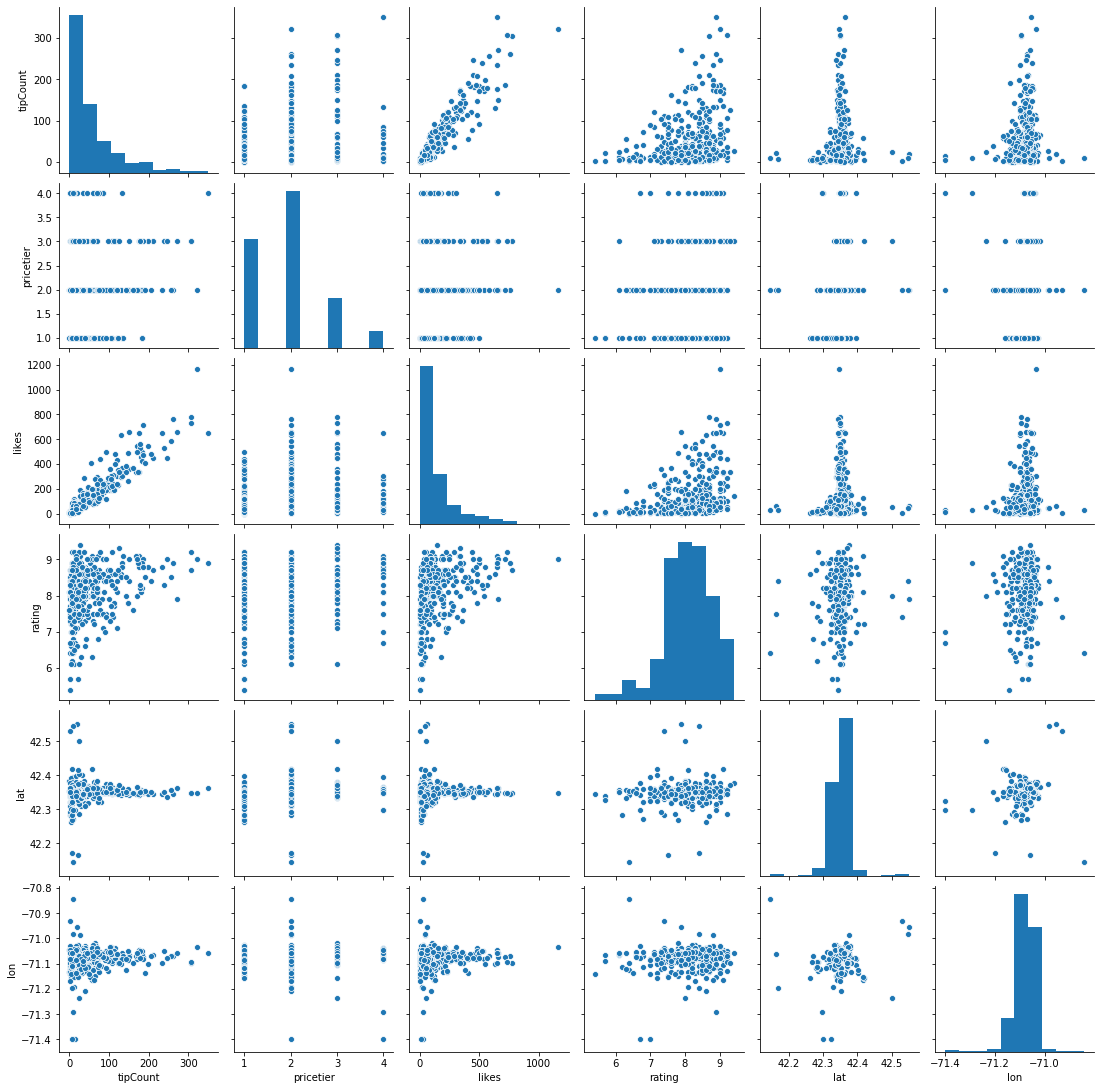

In [270]:
# plot numerical values against each other
sns.pairplot(boston_venues_numeric)

We also visualize the distribution of venues per category. As can be seen below, there is a maximum of 10 venues per category. Some categories, for example Afghan and Dutch restaurants, have only 1-2 venues. These could be eliminated from the analysis since there is likely not enough data to make a prediction, but we will include them in this first iteration of the project.

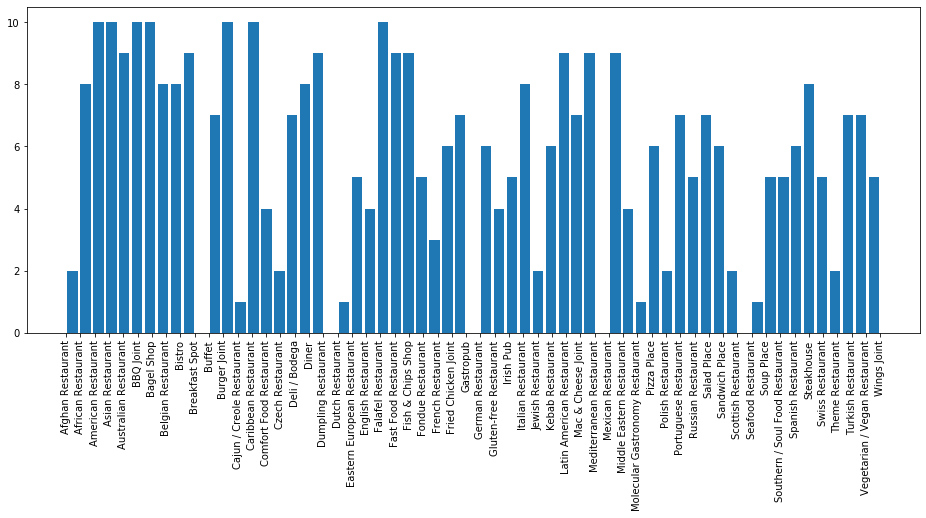

In [180]:
# visualize distributions for categorical variables
boston_venues['category'].hist(xrot = 90, figsize = (16,6), bins = 63, rwidth = .8, grid = False)

Because the restaurant categories were not included in the numerical seaborn pairplots above, we subset the categories by price tier and re-plot them as histograms to see if we can detect any trends. Recall price tier 2 was the most common category.

The three most common venue categories in the lowest price tier, 1, were bagel shops, falafel restaurants, and dumpling restaurants. This is consistent with more less expensive restaurants being lunch/breakfast oriented, usually with fast service and more options for takeaway.

The most common venue category in the most expensive price tier, 4, is clearly the steakhouse. Curiously, there is also a single mac and cheese joint in this subset!

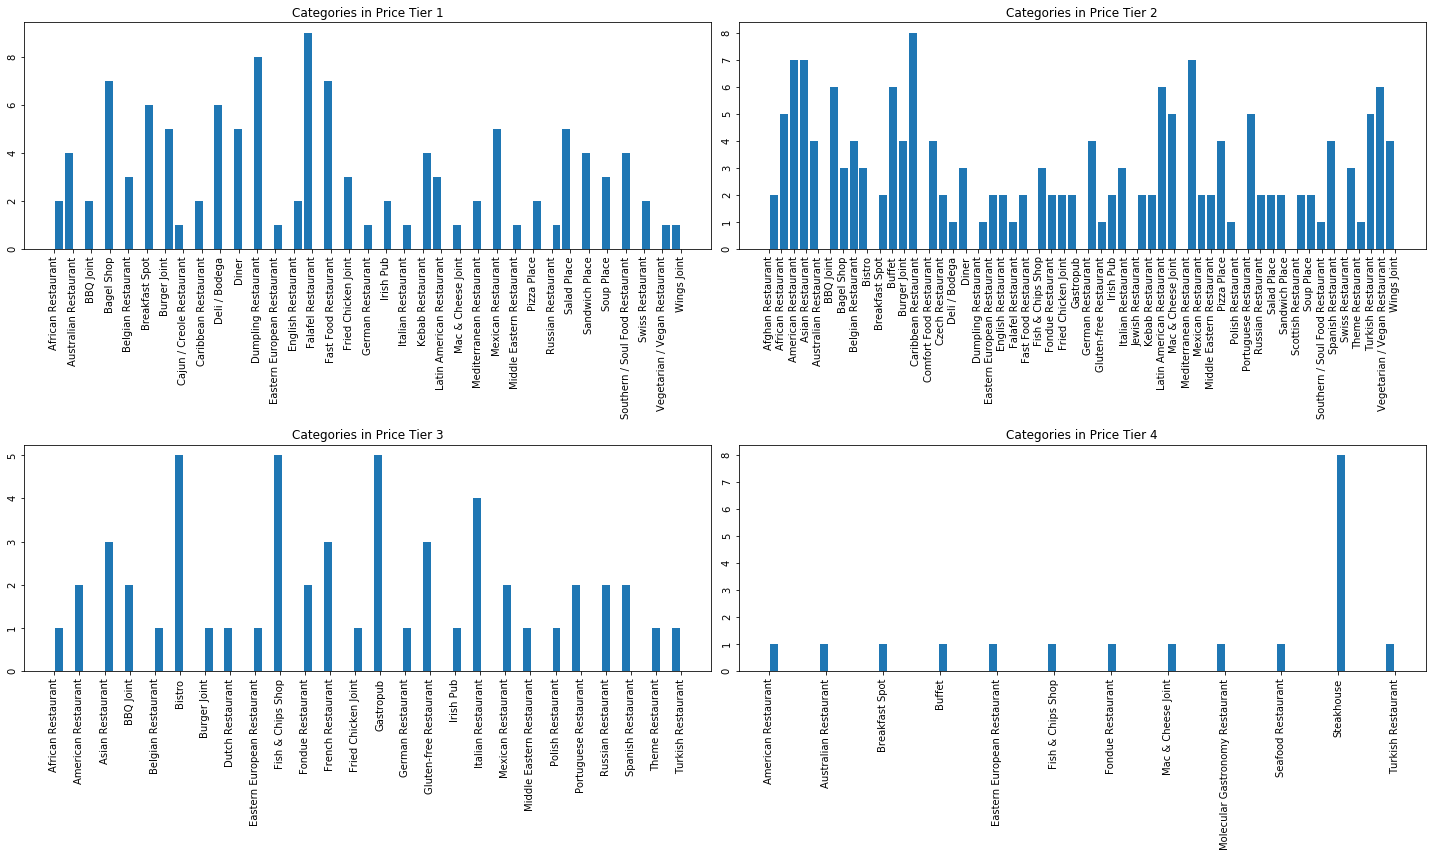

In [182]:
#distribution of categories per price tier (hist)

plt.figure(figsize=(20,12))

#Plot 1
ax1 = plt.subplot(2,2,1)
ax1.hist(boston_venues['category'].loc[boston_venues['pricetier'] == 1], bins = 63, rwidth = .8)
ax1.tick_params(labelrotation=90)
ax1.set_title('Categories in Price Tier 1')

#Plot 2
ax2 = plt.subplot(2,2,2)
ax2.hist(boston_venues['category'].loc[boston_venues['pricetier'] == 2], bins = 63, rwidth = .8)
ax2.tick_params(labelrotation=90)
ax2.set_title('Categories in Price Tier 2')

#Plot 3
ax3 = plt.subplot(2,2,3)
ax3.hist(boston_venues['category'].loc[boston_venues['pricetier'] == 3],bins = 63, rwidth = .8)
ax3.tick_params(labelrotation=90)
ax3.set_title('Categories in Price Tier 3')

#Plot 4
ax4 = plt.subplot(2,2,4)
ax4.hist(boston_venues['category'].loc[boston_venues['pricetier'] == 4], bins = 63, rwidth = .8)
ax4.tick_params(labelrotation=90)
ax4.set_title('Categories in Price Tier 4')

plt.tight_layout() 

### 3.2. Inferential Statistical Testing

After completing our preliminary analysis of the data, we now perform inferential statistical tests to confirm that the data is suitable for use in a machine learning algorithm. First, we use scipy.stats to perform a one way ANOVA test, which compares the means of multiple sample groups to determine whether the groups are pulled from the same population. We compare the mean ratings between different restaurant categories, since this is the basis of our analysis. The results of our test confirm that the underlying sample pools are separate.

In [274]:
#anova - comparison between categories
from scipy.stats import f_oneway                        

grouped = boston_venues.groupby(boston_venues.category)
cat1 = grouped.get_group('Afghan Restaurant')['rating']
cat2 = grouped.get_group('African Restaurant')['rating']
cat3 = grouped.get_group('American Restaurant')['rating']
cat4 = grouped.get_group('Australian Restaurant')['rating']
cat5 = grouped.get_group('BBQ Joint')['rating']
cat6 = grouped.get_group('Bagel Shop')['rating']
cat7 = grouped.get_group('Belgian Restaurant')['rating']
cat8 = grouped.get_group('Bistro')['rating']
cat9 = grouped.get_group('Breakfast Spot')['rating']
cat10 = grouped.get_group('Buffet')['rating']
cat11 = grouped.get_group('Burger Joint')['rating']
cat12 = grouped.get_group('Cajun / Creole Restaurant')['rating']
cat13 = grouped.get_group('Caribbean Restaurant')['rating']
cat14 = grouped.get_group('Comfort Food Restaurant')['rating']
cat15 = grouped.get_group('Czech Restaurant')['rating']
cat16 = grouped.get_group('Deli / Bodega')['rating']
cat17 = grouped.get_group('Diner')['rating']
cat18 = grouped.get_group('Dumpling Restaurant')['rating']
cat19 = grouped.get_group('Dutch Restaurant')['rating']
cat20 = grouped.get_group('Eastern European Restaurant')['rating']
cat21 = grouped.get_group('English Restaurant')['rating']
cat22 = grouped.get_group('Falafel Restaurant')['rating']
cat23 = grouped.get_group('Fast Food Restaurant')['rating']
cat24 = grouped.get_group('Fish & Chips Shop')['rating']
cat25 = grouped.get_group('Fondue Restaurant')['rating']
cat26 = grouped.get_group('Spanish Restaurant')['rating']
cat27 = grouped.get_group('Southern / Soul Food Restaurant')['rating']
cat28 = grouped.get_group('Soup Place')['rating']
cat29 = grouped.get_group('Seafood Restaurant')['rating']
cat30 = grouped.get_group('Scottish Restaurant')['rating']
cat32 = grouped.get_group('Sandwich Place')['rating']
cat33 = grouped.get_group('Salad Place')['rating']
cat34 = grouped.get_group('Russian Restaurant')['rating']
cat35 = grouped.get_group('Asian Restaurant')['rating']
cat36 = grouped.get_group('Portuguese Restaurant')['rating']
cat37 = grouped.get_group('Polish Restaurant')['rating']
cat38 = grouped.get_group('Pizza Place')['rating']
cat39 = grouped.get_group('Molecular Gastronomy Restaurant')['rating']
cat40 = grouped.get_group('Middle Eastern Restaurant')['rating']
cat41 = grouped.get_group('Mexican Restaurant')['rating']
cat42 = grouped.get_group('Mediterranean Restaurant')['rating']
cat43 = grouped.get_group('Mac & Cheese Joint')['rating']
cat44 = grouped.get_group('Latin American Restaurant')['rating']
cat45 = grouped.get_group('Kebab Restaurant')['rating']
cat46 = grouped.get_group('Jewish Restaurant')['rating']
cat47 = grouped.get_group('Italian Restaurant')['rating']
cat48 = grouped.get_group('Irish Pub')['rating']
cat49 = grouped.get_group('Gluten-free Restaurant')['rating']
cat50 = grouped.get_group('German Restaurant')['rating']
cat51 = grouped.get_group('Gastropub')['rating']
cat52 = grouped.get_group('Fried Chicken Joint')['rating']
cat53 = grouped.get_group('French Restaurant')['rating']
cat56 = grouped.get_group('Steakhouse')['rating']
cat57 = grouped.get_group('Swiss Restaurant')['rating']
cat58 = grouped.get_group('Theme Restaurant')['rating']
cat55 = grouped.get_group('Turkish Restaurant')['rating']
cat31 = grouped.get_group('Vegetarian / Vegan Restaurant')['rating']
cat54 = grouped.get_group('Wings Joint')['rating']


F,p = f_oneway(cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,
               cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,
               cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,
               cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat50,cat51,cat52,cat53,
               cat54,cat55,cat56,cat57,cat58)
print("statistic: ",F,", p-value:",p)

statistic:  4.384602586305413 , p-value: 2.410432156342997e-17


Next, we use the shapiro test to determine whether the ratings are normally distributed. Normal distribution is an assumption of our analysis, so it is vital we confirm it before proceeding. The results of the test confirm that ratings are normally distributed. 

In [160]:
shapiro_ratings_test = stats.shapiro(boston_venues['rating'].dropna())
print("shapiro test for normality:",shapiro_ratings_test[0],", p-value:", shapiro_ratings_test[0])

shapiro test for normality: 0.9505376815795898 , p-value: 0.9505376815795898


### 3.3. Machine Learning

To construct a machine learning algorithm, we first confirm that all our data is of the appropriate type. It is.

In [260]:
# check dataframe to ensure data types are correct, fix if not
boston_venues.info()
boston_venues.astype({'tipCount':'float64','likes':'float64'}).dtypes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357 entries, 0 to 420
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   venue_name  357 non-null    object 
 1   tipCount    357 non-null    int64  
 2   pricetier   357 non-null    float64
 3   likes       357 non-null    int64  
 4   rating      357 non-null    float64
 5   lat         357 non-null    float64
 6   lon         357 non-null    float64
 7   category    357 non-null    object 
dtypes: float64(4), int64(2), object(2)
memory usage: 35.1+ KB


venue_name     object
tipCount      float64
pricetier     float64
likes         float64
rating        float64
lat           float64
lon           float64
category       object
dtype: object

Next, because venue category is a categorical variable and our algorithm requires numeric inputs, we use one hot encoding to transform the venue category into a numerical variable.
The one hot encoded categories are then concatenated back onto the original datafram in place of the old 'venue category' column.

In [239]:
#one hot encoding for categorical variables
boston_onehot = pd.get_dummies(boston_venues['category'], prefix="", prefix_sep="")
boston_onehot.head()

boston_venues.drop(['category'], axis = 1).head()
boston_venues_ml = pd.concat([boston_venues, boston_onehot], axis = 1).drop(['venue_name','category'], axis = 1)
boston_venues_ml.head()

,tipCount,pricetier,likes,rating,lat,lon,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Belgian Restaurant,Bistro,Breakfast Spot,Buffet,Burger Joint,Cajun / Creole Restaurant,Caribbean Restaurant,Comfort Food Restaurant,Czech Restaurant,Deli / Bodega,Diner,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,English Restaurant,Falafel Restaurant,Fast Food Restaurant,Fish & Chips Shop,Fondue Restaurant,French Restaurant,Fried Chicken Joint,Gastropub,German Restaurant,Gluten-free Restaurant,Irish Pub,Italian Restaurant,Jewish Restaurant,Kebab Restaurant,Latin American Restaurant,Mac & Cheese Joint,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Molecular Gastronomy Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Russian Restaurant,Salad Place,Sandwich Place,Scottish Restaurant,Seafood Restaurant,Soup Place,Southern / Soul Food Restaurant,Spanish Restaurant,Steakhouse,Swiss Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Wings Joint
0,20,2.0,38,8.3,42.362593,-71.138953,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,71,2.0,137,8.4,42.366529,-71.078079,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,22,2.0,38,8.7,42.322086,-71.109521,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,2.0,10,8.0,42.322339,-71.072645,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,22,2.0,22,7.7,42.336642,-71.076827,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


To evaluate our model, we define an evaluation matrix that computes several key statistics.

In [262]:
#for evaluation of error term and 
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

Finally, we create the algorithm. We have chosen linear regression as our first attempt as it is straightforward to use and robust. THere are several steps to building the algorithm.
First, we split the data into the predictor variables (i.e. everything except the rating) and the variable we want to predict (rating). Then, we split the data into training and testing subsets. We use 70% of our data for training and 30% for testing. Then, we fit a model to the training subsets and compute results.

In [263]:
#linear regression
from sklearn.linear_model import LinearRegression 

X = boston_venues_ml.drop(['rating'], axis = 1)
y = boston_venues_ml['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model = LinearRegression()
model.fit(X_train,y_train)
Results = model_d.predict(X_test).round(decimals = 1)
Results


array([8.4, 8.3, 8.7, 8.4, 8.2, 7.5, 7.6, 8. , 8.3, 8. , 8.3, 7.7, 9.4,
       7.9, 7.4, 8.1, 7.4, 7.5, 7.5, 8.5, 8.2, 7.3, 6.8, 8. , 7.9, 7.4,
       7.9, 7.8, 9.8, 8.6, 9.5, 7.8, 8.8, 7.6, 8.8, 8.5, 7.5, 7.5, 9.5,
       8.5, 8.4, 7.9, 7.6, 7.4, 8.1, 8.4, 8.6, 8.2, 8.5, 8.6, 8.1, 7.6,
       8.2, 8.2, 6.8, 8.2, 8. , 8.9, 8.1, 8.2, 7.7, 7.8, 7.8, 8.3, 8.8,
       7.8, 8.6, 8.6, 7.4, 8.7, 8.3, 7.6, 7.9, 8.3, 8. , 8.3, 8.4, 7.9,
       8.2, 7.8, 6.7, 8.2, 7.7, 7.7, 7.7, 8.9, 8.6, 7.8, 8.1, 7.4, 8.1,
       8.8, 8.2, 8.5, 7.9, 8. , 7.6, 8.3, 9.4, 9.4, 8.4, 8.8, 8.5, 8.1,
       7.5, 8.2, 8.3, 7.6])

The results of our linear regression model are then compared to the testing subset. As can be seen in the plot below, there is a positive correlation between our predicted ratings and the actual ratings, indicating that our model performed well. The predicted mean (8.12) is also quite similar to the actual mean (8.09). 

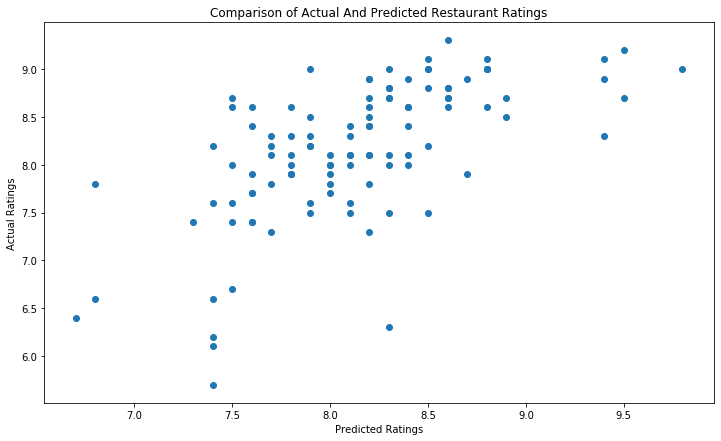

In [276]:
plt.figure(figsize=(12,7))
plt.scatter(Results,y_test)
plt.title('Comparison of Actual And Predicted Restaurant Ratings')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [267]:
print ('Actual mean of population:' + str(y.mean()))
print ('Actual std of population:' + str(y.std()))
print ('Encoding(mean) :'+ str(Results.mean()))
print ('Encoding(std) :'+ str(Results.std()))

Actual mean of population:8.09019607843137
Actual std of population:0.7021149556044609
Encoding(mean) :8.124074074074073
Encoding(std) :0.5638607607166813


## 4. Discussion and Conclusions

Overall, our model is a good first step in constructing a predictive algorithm for restaurant success based on data available from foursquare. Of course, a full scale project of this nature would involve many more interations and more in depth data collection. However, even with our limited data and simple analysis, we were able to construct an algorithm that correlated well wih testing data.

Future improvements to the project could consider whether rating is the optimal indicator to predict restaurant success, as we saw during the data analysis step that few restaurants had low ratings, and many restaurants with high ratings had a low number of likes/tips. Likes or tip counts could be considered as an alternative indicator.
In terms of location, it could be useful to categorize locations into neighbourhoods based on their latitude and longitude. As we noted earlier, a straightforward linear correlation between lat/lon and rating is unlikely. However, by transforming location into a categorical variable then using one hot encoding to include this in the analysis, the importance of location choice for restaurant success may become more apparent. 